## Session 10 - Image search with VGG16 and K-Nearest Neighbours

In [12]:
%pip install numpy
%pip install tqdm
%pip install tensorflow
%pip install matplotlib
%pip install tensorflow_hub
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to us

In [4]:
# base tools
import os, sys
sys.path.append(os.path.join(".."))

# data analysis
import numpy as np
from numpy.linalg import norm
from tqdm import notebook

# tensorflow
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import (load_img, 
                                                  img_to_array)
from tensorflow.keras.applications.vgg16 import (VGG16, 
                                                 preprocess_input)
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2024-04-19 14:09:48.255030: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 14:09:48.259904: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 14:09:48.315857: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 14:09:49.192741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Helper functions

Q: What kind of preprocessing am I doing here? Why do you think I'm doing it?

In [5]:
def extract_features(img_path, model):
    """
    Extract features from image data using pretrained model (e.g. VGG16)
    """
    # Define input image shape - remember we need to reshape
    input_shape = (224, 224, 3)
    # load image from file path
    img = load_img(img_path, target_size=(input_shape[0], 
                                          input_shape[1]))
    # convert to array
    img_array = img_to_array(img)
    # expand to fit dimensions
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # preprocess image - see last week's notebook
    preprocessed_img = preprocess_input(expanded_img_array)
    # use the predict function to create feature representation
    features = model.predict(preprocessed_img, verbose=False)
    # flatten
    flattened_features = features.flatten()
    # normalise features
    normalized_features = flattened_features / norm(features)
    return flattened_features

# Image search

## Load VGG16

In [6]:
model = VGG16(weights='imagenet', 
              include_top=False,
              pooling='avg',
              input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Extract features from single image

In [7]:
target_image = os.path.join("..", "..","..","..", "cds-vis-data", "data", "img", "florence.jpg")
features = extract_features(target_image, model)

In [8]:
features

array([1.40007484e+00, 0.00000000e+00, 1.89000845e-01, 6.62067235e-01,
       1.51665936e+01, 0.00000000e+00, 0.00000000e+00, 1.04001081e+00,
       0.00000000e+00, 0.00000000e+00, 1.10624579e-03, 0.00000000e+00,
       1.22243173e-01, 0.00000000e+00, 2.58846831e+00, 0.00000000e+00,
       0.00000000e+00, 1.95303965e+00, 7.72281885e-01, 0.00000000e+00,
       0.00000000e+00, 1.33256167e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.81745863e+00, 0.00000000e+00, 0.00000000e+00,
       1.47842312e+00, 6.88361451e-02, 5.28677940e+00, 0.00000000e+00,
       2.45790705e-02, 0.00000000e+00, 4.35872823e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.84966362e+00, 1.91122484e+00, 0.00000000e+00,
       7.02198029e+00, 2.09627819e+01, 5.37744379e+00, 0.00000000e+00,
       2.01789856e+00, 1.21550703e+00, 3.72341228e+00, 1.52538881e-01,
       6.86924398e-01, 5.20135164e+00, 5.31802654e-01, 5.60718203e+00,
      

## Iterate over folder

In [9]:
# path to the datasets
root_dir = os.path.join("..","..", "..", "..", "cds-vis-data", "flowers")
filenames = [root_dir + "/" + name for name in sorted(os.listdir(root_dir))]

__Extract features for each image__

In [10]:
feature_list = []
# iterate over all files with a progress bar
for i in notebook.tqdm(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

  0%|          | 0/1360 [00:00<?, ?it/s]

## Nearest neighbours

Once we have our *database* of extracted embeddings, we can then use K-Nearest Neighbours to find similar images.

In [13]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=10, 
                             algorithm='brute', #calculates cosine for every image, possoble since data is small
                             metric='cosine').fit(feature_list)

__Calculate nearest neighbours for target__

In [14]:
distances, indices = neighbors.kneighbors([feature_list[250]])

__Save indices, print data__

In [15]:
idxs = []
for i in range(1,6): #starting from 1 because the imiage most similar is the image itself and we dont want that, so we start from the second image (1) to closest 5 (6)
    print(distances[0][i], indices[0][i])
    idxs.append(indices[0][i])

0.14842796 248
0.21073085 249
0.21198976 245
0.22384572 244
0.22834104 240


__Plot target image__

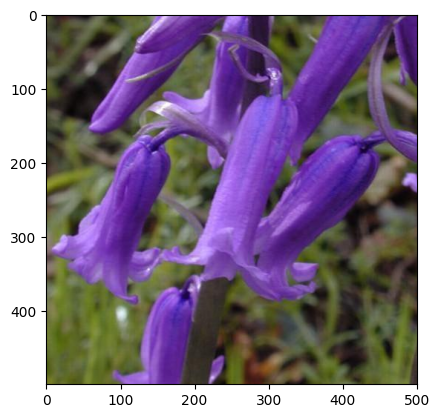

In [16]:
plt.imshow(mpimg.imread(filenames[250]))

__Plot close images__

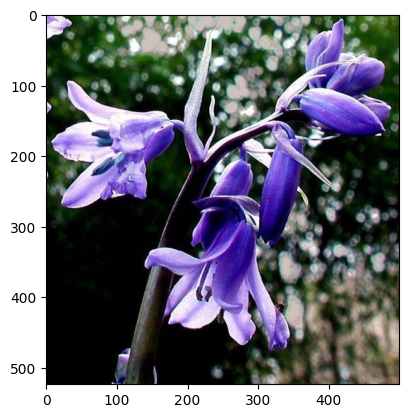

In [18]:
plt.imshow(mpimg.imread(filenames[249]))
plt.imshow(mpimg.imread(filenames[244])) #etc. 

__Plot target and top 3 closest together__

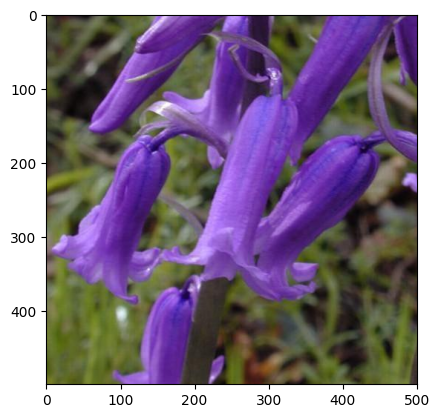

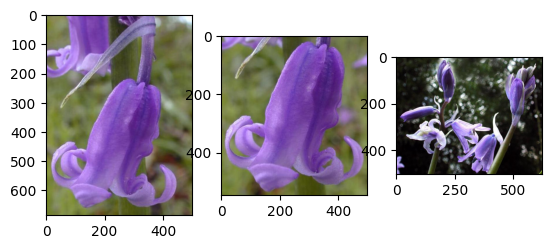

In [19]:
# plt target
plt.imshow(mpimg.imread(filenames[250]))

# plot 3 most similar
f, axarr = plt.subplots(1,3)
axarr[0].imshow(mpimg.imread(filenames[idxs[0]]))
axarr[1].imshow(mpimg.imread(filenames[idxs[1]]))
axarr[2].imshow(mpimg.imread(filenames[idxs[2]]))

## Simple style transfer

__Load a quick style transfer model from TF Hub__

You can find more details [here](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization).

You can also play around with an interactive version with the same model at [this website](https://reiinakano.com/arbitrary-image-stylization-tfjs/).

In [20]:
from utils.styletransfer import st_load, show_n
# Load TF-Hub module.
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

__Load the content image and the style image__

In [21]:
content_image = st_load(os.path.join("..","..","..", "..", "cds-vis-data", "data", "img", "florence.jpg"))
style_image = st_load(os.path.join("..", "..","..","..", "cds-vis-data", "data", "img", "starry_night.jpg"))

__Process using the model__

In [22]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

__Show content, style, and stylized image__

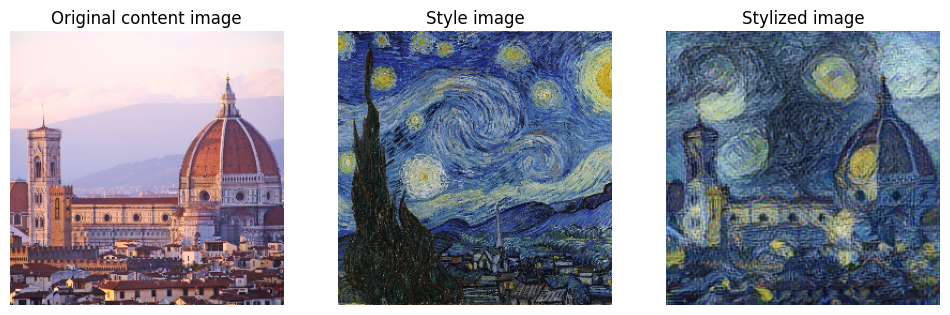

In [23]:
show_n([content_image, style_image, stylized_image], 
       titles=['Original content image', 'Style image', 'Stylized image'])

### Tasks

- Take the code in this notebook and turn it into a Python script. You can then add this to the repo for your Assignment 1 solution for creating doing image search
  - I.e. your Assignment 1 repo would contain both code for image search using colour histograms *and* for image search using a pretrained CNN.